In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import scipy
import seaborn as sns
import sklearn
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools import get_positive_contributions, compute_entropy, print_equations
from data_func import plot_clustered_kuramoto, generate_kuramoto_cluster_data_sin_cos
import warnings
from sklearn.exceptions import ConvergenceWarning

# 仅忽略收敛警告
warnings.filterwarnings("ignore", category=ConvergenceWarning)


pipline操作流程：

1.生成数据：a 单起始点时间序列；b 多起始点时间序列

可选步骤：时间序列降采样

2.选择合适的library做观测

3.选择合适的optimizer做拟合：a 离散的迭代方程；b 连续的微分方程

4.计算score，多步预测效果看一下

5.提取系数矩阵，进行svd分解，得到奇异值谱和左奇异向量

6.观察奇异值谱截断，计算因果涌现程度，绘制多尺度contribution，计算EC

7.根据奇异向量和谱截断，输出粗粒化函数表达式

8.绘制宏观演化的时间序列，给出宏观动力学方程

可选的分析案例：

1.SIR：原始的SIR动力学；带观测噪音的四维微观数据

2.kuramoto模型

3.洛伦兹动力学

4.耦合Rulkov映射

# 数据生成

In [3]:
N=10
n_clusters=2  # 团数
K_intra=5
K_inter=0.11
noise=0
dt=0.01

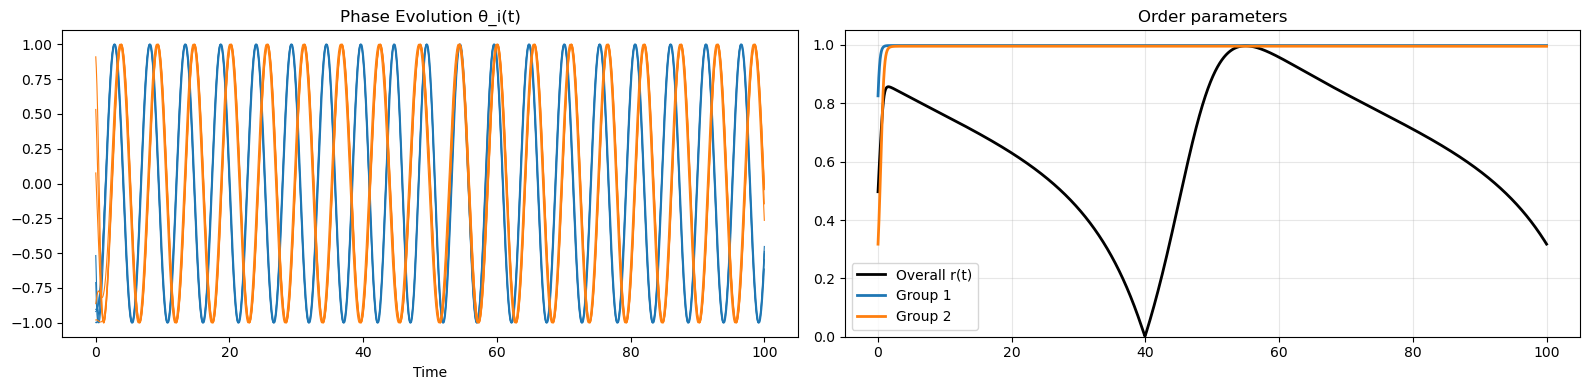

In [4]:
# 单时间序列采样
x_train, theta_hist, t_train, K_matrix = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=n_clusters,  # 团数
    K_intra=K_intra,   # 团内耦合
    K_inter=K_inter,   # 团间耦合
    noise=noise,
    T=100,
    random_seed1=41, random_seed2=2000,
    dt=dt
)

x_data = x_train


# 选择library

In [5]:
# 候选的观测函数
ide = ps.IdentityLibrary()
fourier = ps.FourierLibrary(n_frequencies=1)
ode_lib = ps.PolynomialLibrary(degree=1,include_bias=True)
library_functions = [
    lambda x: x,
    lambda x: np.sin(x),
    lambda x: np.cos(x),
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

# 选定观测函数
library = ide + fourier

# 进行lift
library.fit(x_data)
x_data_lift = library.transform(x_data)
names = library.get_feature_names()

# 单时间序列
print(x_data_lift.shape)
# 多时间序列
#print(x_data_lift[0].shape)
# 检查观测函数变量名
print(names)

(10000, 60)
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'sin(1 x0)', 'cos(1 x0)', 'sin(1 x1)', 'cos(1 x1)', 'sin(1 x2)', 'cos(1 x2)', 'sin(1 x3)', 'cos(1 x3)', 'sin(1 x4)', 'cos(1 x4)', 'sin(1 x5)', 'cos(1 x5)', 'sin(1 x6)', 'cos(1 x6)', 'sin(1 x7)', 'cos(1 x7)', 'sin(1 x8)', 'cos(1 x8)', 'sin(1 x9)', 'cos(1 x9)', 'sin(1 x10)', 'cos(1 x10)', 'sin(1 x11)', 'cos(1 x11)', 'sin(1 x12)', 'cos(1 x12)', 'sin(1 x13)', 'cos(1 x13)', 'sin(1 x14)', 'cos(1 x14)', 'sin(1 x15)', 'cos(1 x15)', 'sin(1 x16)', 'cos(1 x16)', 'sin(1 x17)', 'cos(1 x17)', 'sin(1 x18)', 'cos(1 x18)', 'sin(1 x19)', 'cos(1 x19)']


# 进行拟合

In [11]:
# 离散的迭代方程 or 连续的微分方程
discrete_time=False

# 候选拟合器
sr3_optimizer = ps.SR3(reg_weight_lam=0.2, regularizer="l2")
lasso_optimizer = Lasso(alpha=0.004, max_iter=20000, fit_intercept=True)
stlsq_optimizer = ps.STLSQ(threshold=0.01, alpha=0.9, verbose=True)

optimizer = lasso_optimizer

# 进行拟合
model = ps.SINDy(feature_library=ide, optimizer=optimizer, discrete_time=discrete_time)
model.fit(x_data_lift, t=dt, feature_names=names)
model.print()

(x0)' = 0.008 x5 + -0.504 x10 + -0.064 x11 + -0.235 x12 + -0.333 x13 + -0.068 x14
(x1)' = 0.008 x5 + -0.420 x10 + -0.140 x11 + -0.241 x12 + -0.051 x13 + -0.350 x14
(x2)' = 0.002 x6 + 0.005 x9 + -0.185 x10 + -0.350 x11 + -0.237 x12 + -0.431 x14
(x3)' = 0.015 x5 + -1.211 x13
(x4)' = 0.005 x5 + 0.005 x7 + -0.009 x13 + -1.199 x14
(x5)' = 0.023 x3 + -0.924 x15 + -0.023 x16 + -0.158 x18
(x6)' = 0.030 x4 + -0.023 x6 + -1.374 x16 + 0.262 x17
(x7)' = 0.024 x4 + -0.049 x5 + -0.469 x16 + -0.626 x17
(x8)' = 0.024 x3 + 0.002 x7 + -0.950 x18 + -0.158 x19
(x9)' = 0.005 x3 + 0.024 x4 + 0.005 x5 + -1.113 x19
(x10)' = 1.155 x0 + 0.001 x1 + 0.042 x3 + -0.004 x5 + 0.013 x19
(x11)' = 0.087 x0 + 1.111 x1 + -0.002 x5 + 0.013 x19
(x12)' = 0.112 x0 + 0.551 x1 + 0.136 x2 + 0.403 x4 + 0.001 x16 + 0.006 x19
(x13)' = 0.285 x2 + 0.936 x3 + 0.005 x10 + 0.032 x11 + 0.025 x17
(x14)' = 1.078 x2 + 0.140 x4 + -0.038 x13 + 0.026 x17
(x15)' = -0.001 x4 + 0.664 x6 + 0.434 x7 + 0.017 x13 + 0.172 x16
(x16)' = 1.117 x6 + 0.010

In [12]:
# 计算score
model.score(x_data_lift, t=dt)

0.9501695514710947

# 多步预测

In [ ]:
# 单时间序列
init_data = x_data_lift[0,:]
# 多时间序列
#init_data = x_data_lift[0][0,:]

if discrete_time:
    X_data_predicted = model.simulate(init_data,len(t_train)-1)
else:
    X_data_predicted = model.simulate(init_data,t_train) 

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_95828/1703944219.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


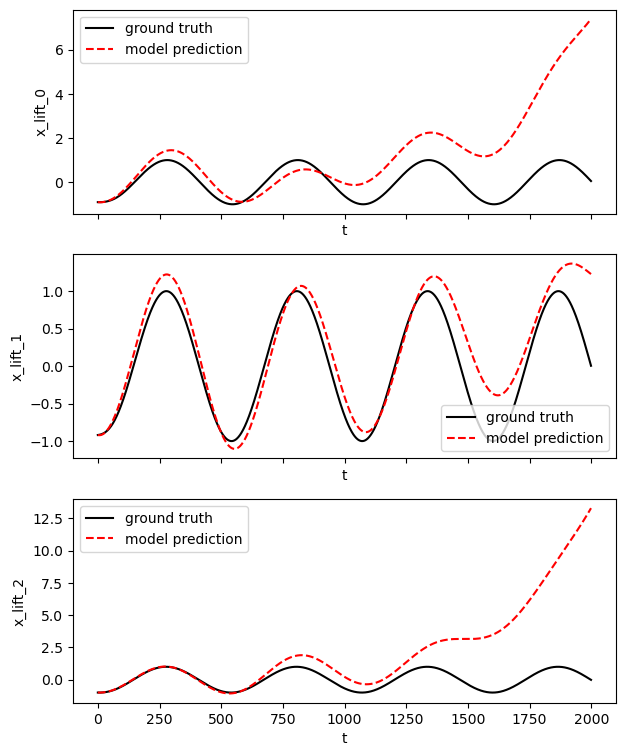

In [18]:
# 只看部分维度的多步预测
steps = 2000
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(x_data_lift[:steps, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:steps, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

# svd分解

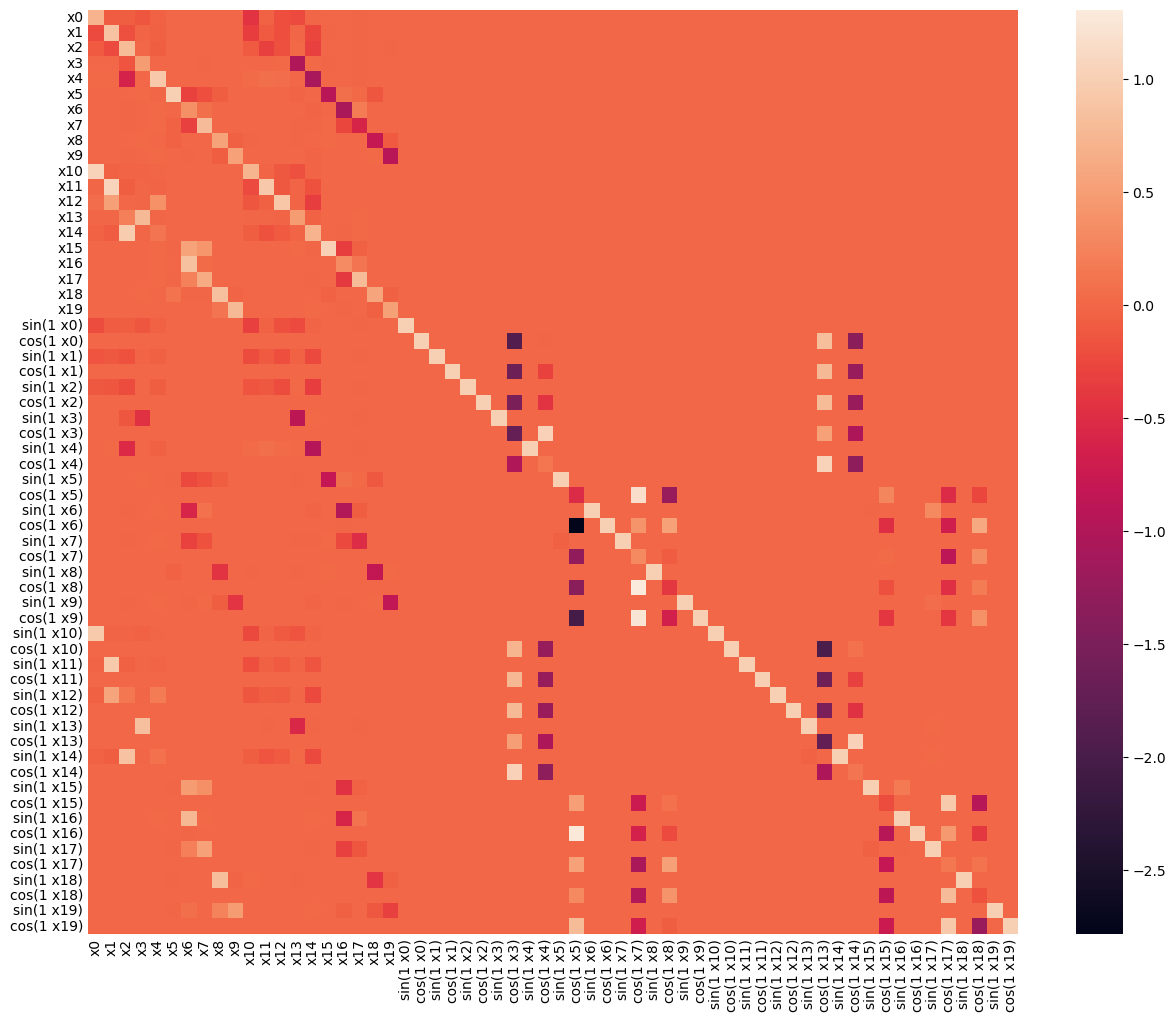

In [14]:
# 提取和处理系数矩阵
A = model.coefficients()
if discrete_time==False:
    A = scipy.linalg.expm(A)

# 只设置参数，不自动显示全部
plt.figure(figsize=(15, 12)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=names, yticklabels=names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

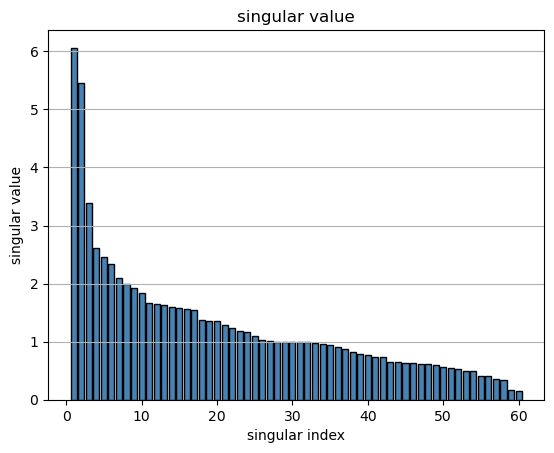

In [15]:
# SVD
U,S,V = np.linalg.svd(A)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

In [19]:
# 选取截断
rank = 2
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

4.489796119502212


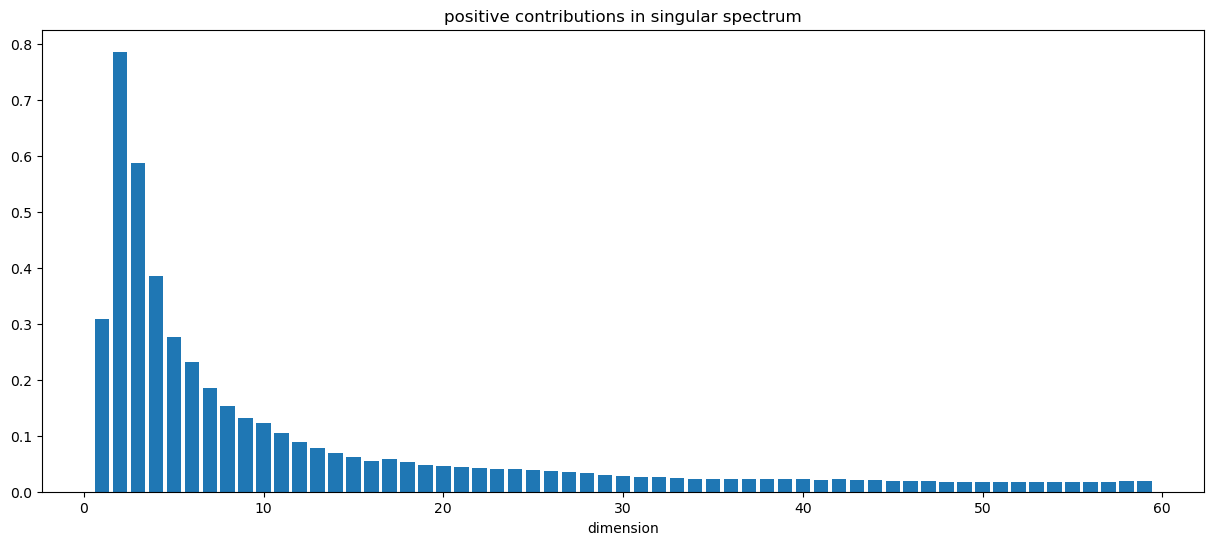

In [20]:
# 多尺度因果力分布
diff = get_positive_contributions(S)
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [21]:
# 计算EC
print(compute_entropy(diff))

4.771670063172314


# 输出粗粒化表达式

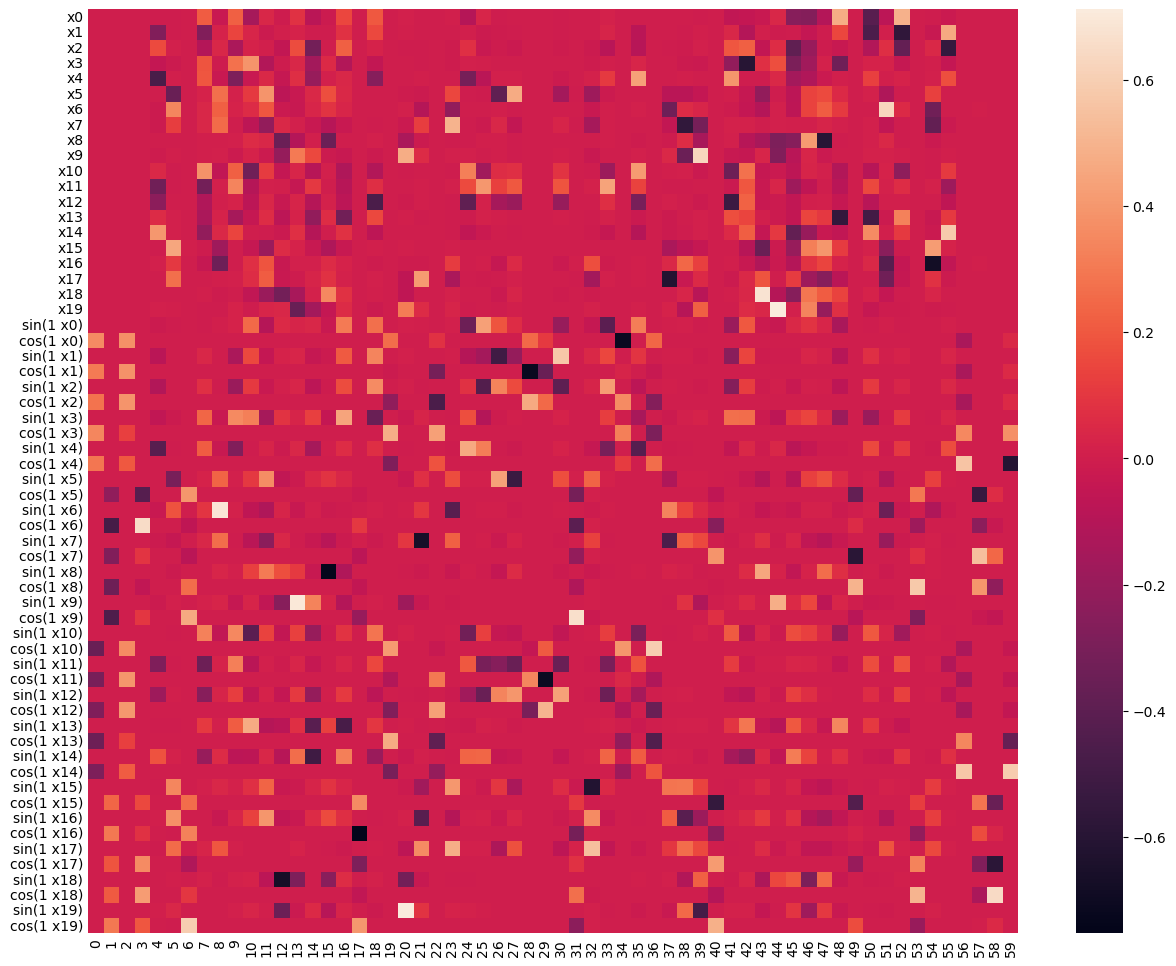

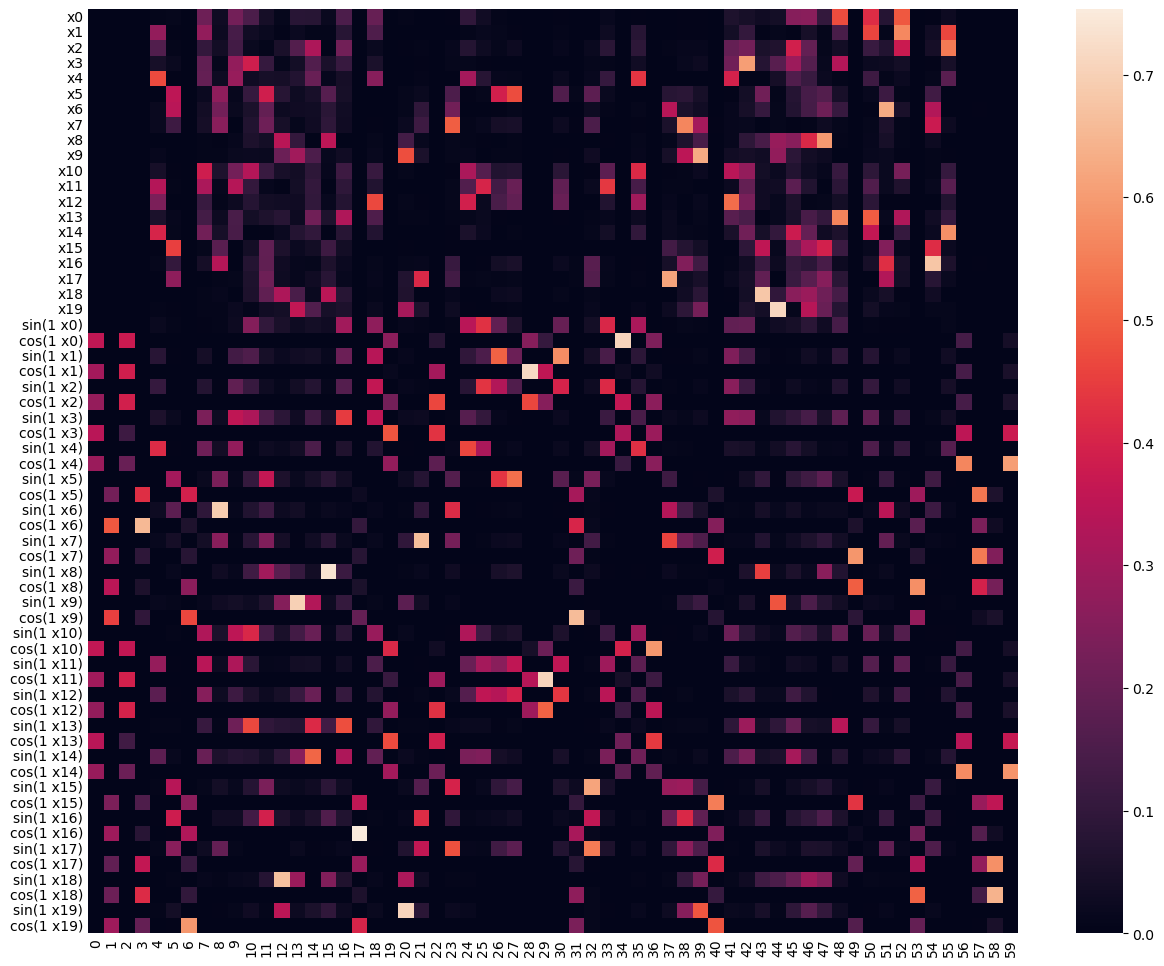

In [22]:
# 绘制奇异向量
U_abs = np.abs(U)

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

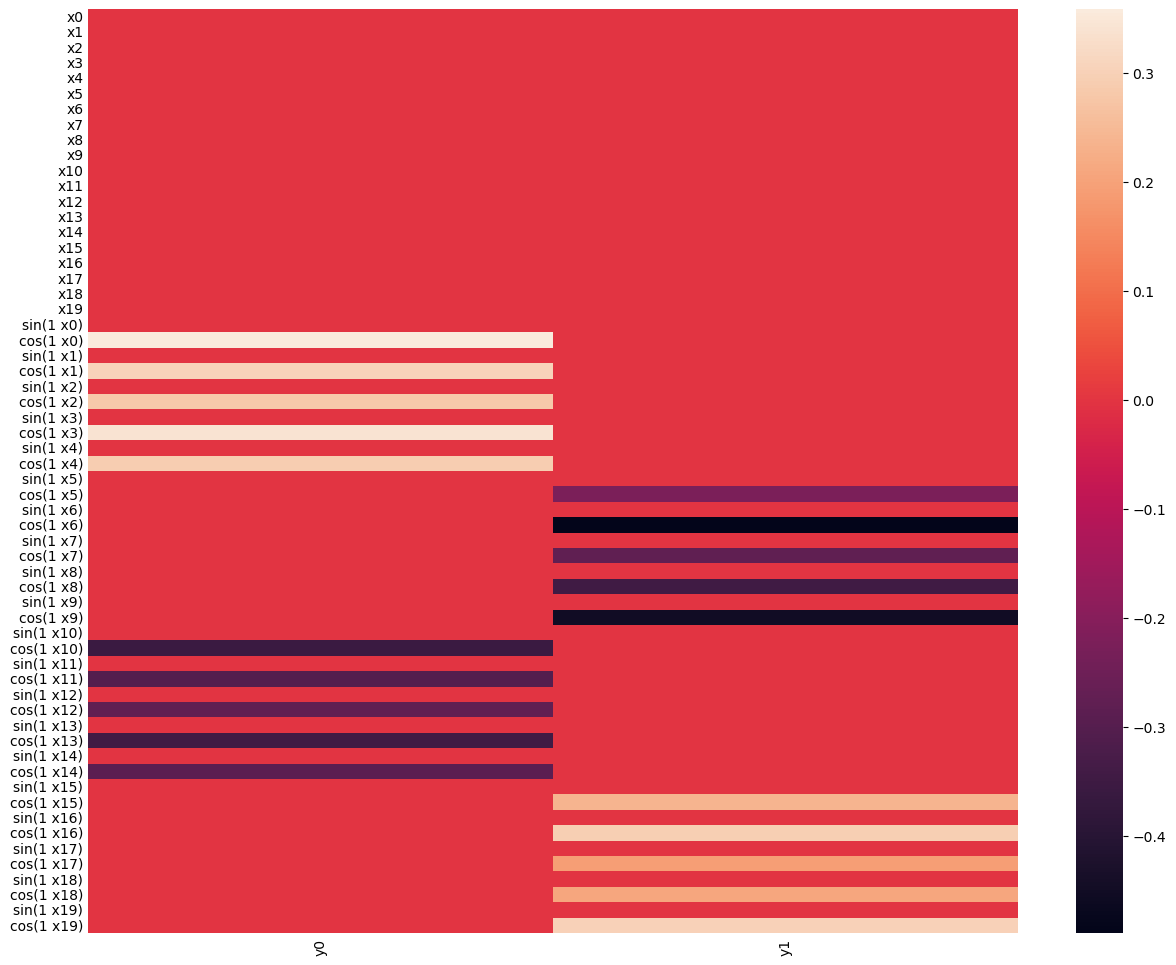

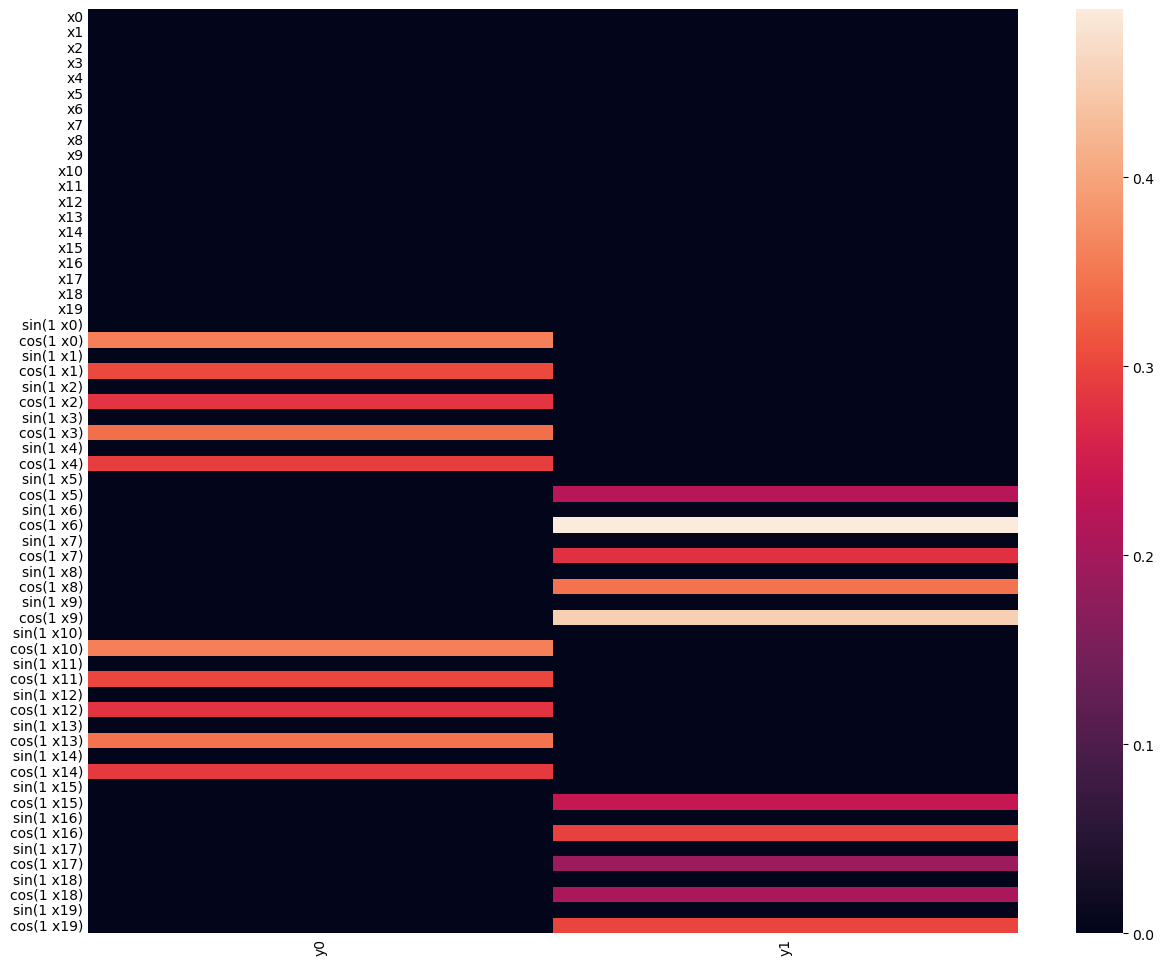

In [23]:
# 粗粒化函数系数
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [24]:
# 输出粗粒化函数表达式
print_equations(coarse_grain_coff, names, macro_name)

y0 = 0.3586 * cos(1 x0) + 0.3035 * cos(1 x1) + 0.2821 * cos(1 x2) + 0.3415 * cos(1 x3) + 0.2910 * cos(1 x4) - 0.3578 * cos(1 x10) - 0.3014 * cos(1 x11) - 0.2793 * cos(1 x12) - 0.3442 * cos(1 x13) - 0.2883 * cos(1 x14)
------------------------------
y1 = 0.0001 * x5 - 0.0003 * x6 + 0.0000 * x7 - 0.0002 * x15 - 0.0002 * x16 - 0.0002 * x17 + 0.0001 * sin(1 x5) - 0.2224 * cos(1 x5) - 0.0001 * sin(1 x6) - 0.4890 * cos(1 x6) + 0.0000 * sin(1 x7) - 0.2773 * cos(1 x7) - 0.3444 * cos(1 x8) - 0.4518 * cos(1 x9) - 0.0002 * sin(1 x15) + 0.2383 * cos(1 x15) - 0.0003 * sin(1 x16) + 0.2948 * cos(1 x16) - 0.0001 * sin(1 x17) + 0.1899 * cos(1 x17) + 0.2064 * cos(1 x18) - 0.0000 * sin(1 x19) + 0.2992 * cos(1 x19)
------------------------------


# 描述宏观演化

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_95828/580934310.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


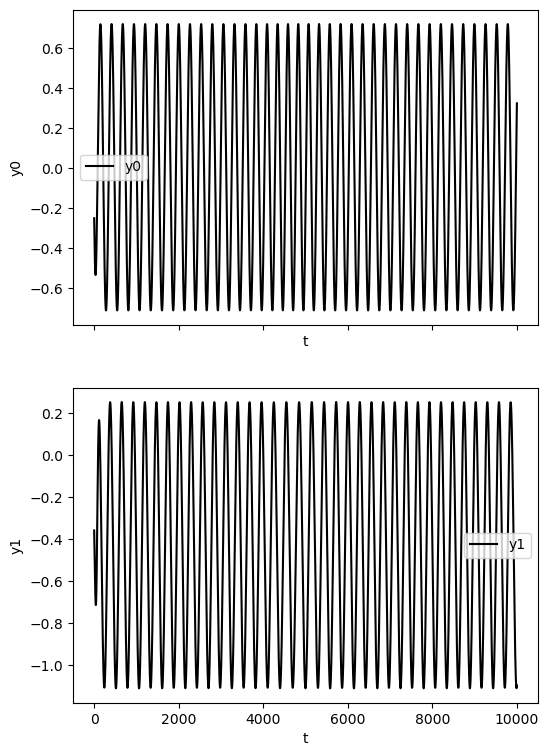

In [25]:
macro_data = x_data_lift @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(int(3*macro_dim), 9))
for i in range(macro_dim):
    axs[i].plot(macro_data[:, i], "k", label=f"y{i}")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=f"y{i}")
fig.show()

In [26]:
# 给出宏观动力学方程
A_macro = coarse_grain_coff.T @ A @ coarse_grain_coff
macro_name_k = [i+'[k]' for i in macro_name]
macro_name_next = [i+'[k+1]' for i in macro_name]
print_equations(A_macro, macro_name_k, macro_name_next)

y0[k+1] = -0.7256 * y0[k]
------------------------------
y1[k+1] = 0.1829 * y1[k]
------------------------------


# 频谱分析

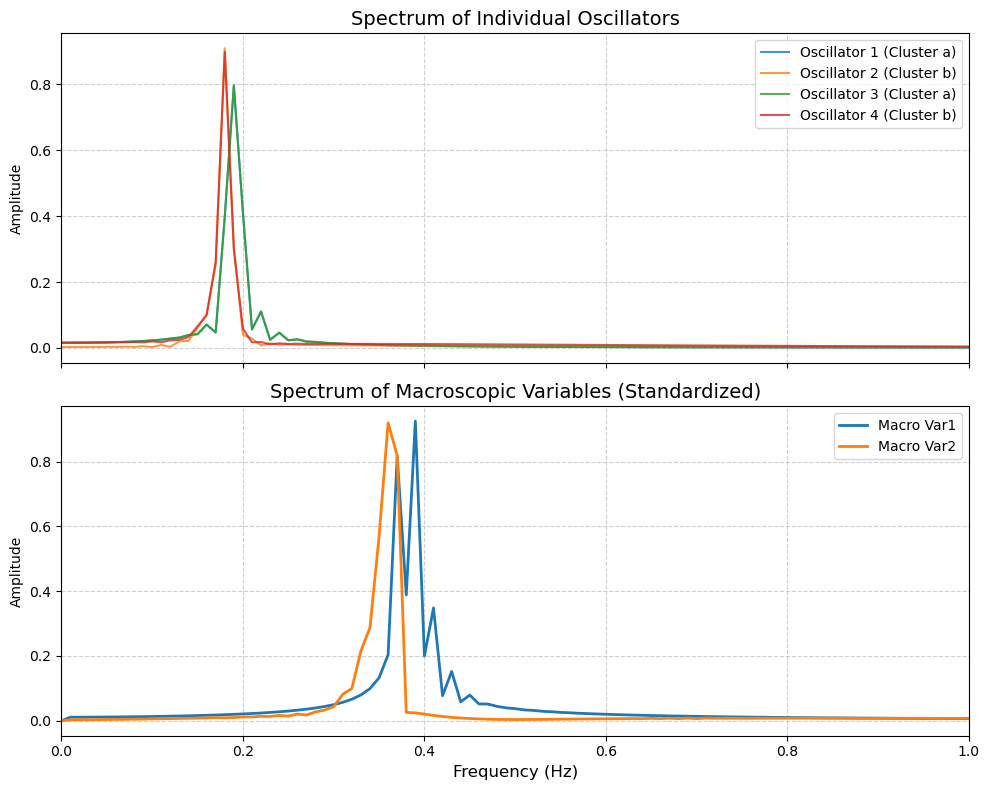

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

N=len(macro_data[:,0])
xf = np.fft.fftfreq(N, dt) 

micro_signals = [x_data[:, 0], x_data[:, 5], x_data[:, 1], x_data[:, 6]]
micro_labels = [
    'Oscillator 1 (Cluster a)', 
    'Oscillator 2 (Cluster b)', 
    'Oscillator 3 (Cluster a)', 
    'Oscillator 4 (Cluster b)'
]

# 扩充 Colors：使用不同颜色区分不同指标，或同色系区分不同集群
# 这里补充了绿色和红色，分别对应蓝、橙、绿、红
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] 

macro_signals = []
for i in range(macro_dim):
    sig = macro_data[:,i]
    standardized_sig = (sig - np.mean(sig) ) / np.std(sig)
    macro_signals.append(standardized_sig)
macro_labels = ['Macro Var1', 'Macro Var2', 'Macro Var3']

def compute_fft(signal, xf, N):
    yf = fft(signal)
    half_n = N // 2
    return xf[:half_n], np.abs(yf[:half_n]) / N * 2  # 归一化幅值


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- 第一幅图：原振子数据的频谱 ---
for i, sig in enumerate(micro_signals):
    freqs, amps = compute_fft(sig, xf, N)
    ax1.plot(freqs, amps, label=micro_labels[i], color=colors[i], alpha=0.8)

ax1.set_title("Spectrum of Individual Oscillators", fontsize=14)
ax1.set_ylabel("Amplitude")
ax1.legend(loc="upper right")
ax1.grid(True, linestyle='--', alpha=0.6)

# --- 第二幅图：宏观变量的频谱 (已标准化) ---
for i, sig in enumerate(macro_signals):
    freqs, amps = compute_fft(sig, xf, N)
    ax2.plot(freqs, amps, label=macro_labels[i], color=colors[i], linewidth=2)

ax2.set_title("Spectrum of Macroscopic Variables (Standardized)", fontsize=14)
ax2.set_xlabel("Frequency (Hz)", fontsize=12)
ax2.set_ylabel("Amplitude")
ax2.legend(loc="upper right")
ax2.grid(True, linestyle='--', alpha=0.6)

# 设置显示范围 (为了看清主峰，限制x轴范围)
ax2.set_xlim(0, 1) 

plt.tight_layout()
plt.show()
